## **PyPPSinflation notebook 1: Numerical PPS**

This can be considered the first notebook of PyPSSinflation. 

# **Numerical Solution of Primordial Power Spectra**

In this Jupyter notebook, we demonstrate how to numerically solve the inflaton background field and the Mukhanov-Sasaki equation to obtain the scalar and tensor primordial power spectra (PPS).

## Overview
1. **Background Field Dynamics:** we start by solving the dynamics of the inflaton background field.
2. **Hubble Flow Functions and end of inflation:** we define the HHFs $\epsilon_i$ and we set the end of inflation when $\epsilon_1(\phi_{end})=1$. 
3. **Mukhanov-Sasaki Equation and Primordial Power Spectra:** we solve the Mukhanov-Sasaki perturbative equation for both scalar and tensor perturbations.We obtain the primordial power spectra (PPS).
4. **The PPS normalization procedure:** here we descuss in general how to deal with the normalization of our constants by choosing a reference value for the scalar PSS.  
5. **Spectral indices and their runnings:** by numerically deriving the PPS, we compute the spectral indices, their runnings, and the runnings of the runnings.

## Background Field Dynamics:

The dynamical system of $\phi$ is made up by the Firedmann equation + Klein Gordon equation: 

$ \begin{cases}
\ddot \phi + 3H\dot \phi + V_{,\phi} =0 \\ 3M^2_{\text{Pl}} H^2 = \frac{1}{2}\dot \phi^2 + V(\phi)
\end{cases}$

Let's write the dynamical system as a system of first order equations to be able to solve it in Python (SciPy can only solve coupled first order ODEs, any second order ODE can be turned into two coupled first order ODEs). 

**Step 1**: Let's write the system as a system of 1th order equations. 

$d\phi = \psi dt  \ \ ⟹ \ \ \psi = \dot \phi$ 

Then

$ \begin{cases}
\psi= \dot \phi \\ \dot{\psi} + 3H\psi + V_{,\phi} =0 \\ 3M^2_{\text{Pl}} H^2 = \frac{1}{2}\psi^2 + V(\phi)
\end{cases}$

**Step 2**: Let's switch from $t$ to the number of e-folds $N$ as variable: 

$ dN = Hdt \ \ ⟹ \ \ N_{tot} = \int_{t_S}^{t_E} Hdt, $ 

which also means

$\frac{d}{dt} = H \frac{d}{dN}$. 

Then the dynamical system will become 

$\begin{cases}
\psi = H\phi_N \\ \psi_N =-3\psi - \frac{V_{,\phi}}{H} \\ 3H^2 =\frac{1}{M^2_{\text{Pl}}} \left( \frac{\psi^2}{2}+V(\phi) \right) 
\end{cases} \ \ \ with \ \ \ (...)_N \equiv \frac{d(...)}{dN}.$



**Step 3**: Substituting Firedmann in Klein-Gordon (III into II) we have $H = \frac{1}{M_{\text{Pl}}} \sqrt{\frac{\frac{\psi^2}{2} + V(\phi)}{3}}$ and then the final system is

$\begin{cases}
\phi_N = \frac{\psi }{H} = \psi M_{\text{Pl}} \sqrt{\frac{3}{\frac{\psi^2}{2}+ V(\phi)}} \\ \psi_N = -3\psi - V_{,\phi} M_{\text{Pl}}\sqrt{\frac{3}{\frac{\psi^2}{2}+ V(\phi)}}
\end{cases} \ \ \ \ \ with \ \ H = \frac{1}{M_{\text{Pl}}} \sqrt{\frac{\frac{\psi^2}{2} + V(\phi)}{3}}$


We have a system of equations and it is useful to define a vector $S=(\phi,\psi)$. The system will be $S_N =\frac{dS}{dN} =\left( \frac{d\phi}{dN},  \frac{d\psi}{dN}\right) = (\phi_N, \psi_N)$.

***A note on the initial conditions***: 

Using the slow roll approximation, it is possibile to write 

$\frac{\dot \phi}{M^2_{Pl} H} \simeq -\frac{V_{,\phi}}{V},$

this implies that

$\phi_N \sim -M^2_{Pl}\frac{V_{,\phi}}{V}$.

It means that, by def. of $\psi$,

$\psi_0= H(\phi_0)\phi_{0N}$. 

Inverting our $H$ formula and rewriting $\psi = H\phi_N$ we get

$H = \sqrt{\frac{2V}{6M^2_{Pl} -\phi^2_N}}$. 

Then we can write our initial condition as

$\psi_0 = \sqrt{\frac{2V}{6M^2_{Pl} -\phi^2_{0N}}} \phi_{0N} \ \ \ where \ \ \ \phi_{0N} =-M^2_{Pl}-\frac{V_{,\phi}(\phi_0)}{V(\phi_0)} $. 


N.B.: By using these formulas we should be able write another background resolution script, avoiding $\psi$ and writing everything with respect to $\phi_N$. Thre procedure is the same, then we have choose to work with $\psi$. 

To present the PyPPSinflation script, we use as an example the Kachru-Kallosh-Linde-Trivedi (KKLT) model of inflation, see e.g. S. Kachru, R. Kallosh, A. Linde and S.P. Trivedi, de Sitter vacua in string theory,
Phys. Rev. D 68 (2003) 046005 [hep-th/0301240].

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
#Model

#Definition of the parameters

Mpl=1
m2num= (1.0313695717893807*1.000000134068844)**(1/2)*1.733192366526448e-05 #Choosing a certain coupling constant, 
                                                #we renormalize it to obtain the scalar PS = 2e-9 
                                                #at the pivot scale (see later in the code).
                                                #This is a squared mass.
                                                # For the first run, put (1)**(1/2), then put the normalization factor.
                                                # We renormalized twice to obtain higher sensitivity.
            
mu = 1

# Definition of the potential. We use the KKLT model as an example:  M^4 (1+mu/\phi)^-1

def V(phi):
    return m2num**2 * (1+mu/phi)**(-1)

def dV(phi):
    return (m2num**2 *mu)/((mu+phi)**2)

In [3]:
# Initial condition for the background

phi_0 = 6* Mpl #Choose it to obtain the field start to decrease at least 55 e-folds before the end of inflation
phi0_N = -dV(phi_0)/V(phi_0) 
psi_0 =  np.sqrt (2.0 * V(phi_0)) * phi0_N / np.sqrt(6.0 - phi0_N**2)

IC_bkg = [phi_0, psi_0]

In [4]:
# Solving the background from N_start to N_stop with N_iter steps

N_start = 0
N_stop = 100
N_iter = 10000

N_bkg = np.zeros(N_iter)
N_bkg = np.linspace(N_start, N_stop, N_iter)


def diff_bkg(S, N): 
    phi, psi = S
    return [psi / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi))), 
          -3 * psi - dV(phi) / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi)))]

sol_bkg = np.zeros(N_iter)
sol_bkg = odeint(diff_bkg, IC_bkg, N_bkg)

phi_bkg = np.zeros(N_iter)
psi_bkg = np.zeros(N_iter)

phi_bkg = sol_bkg[:,0]
psi_bkg = sol_bkg[:,1]

/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_4957/863173537.py:13: RuntimeWarning: invalid value encountered in sqrt
  return [psi / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi))),
/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_4957/863173537.py:14: RuntimeWarning: invalid value encountered in sqrt
  -3 * psi - dV(phi) / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi)))]


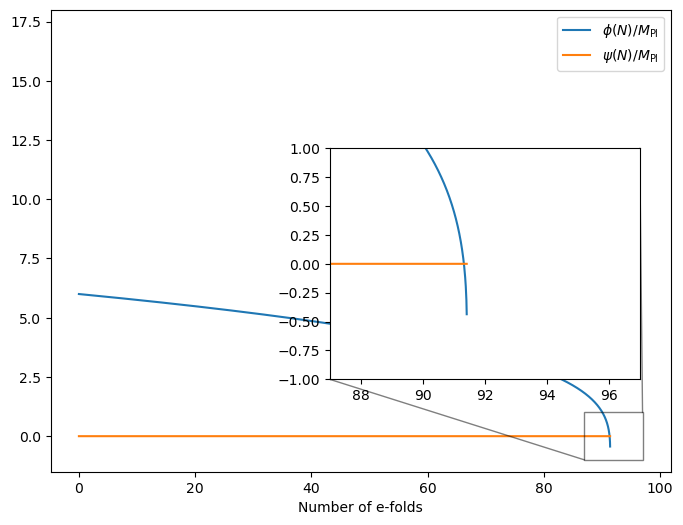

In [5]:
#Plotting \phi and \psi in units of M_planck

fig, ax = plt.subplots(figsize=[8, 6])

ax.plot(N_bkg, phi_bkg, label=r'$\phi(N) / M_{\rm Pl}$')
ax.plot(N_bkg, psi_bkg, label=r'$\psi(N) / M_{\rm Pl}$')

ax.set_ylim([-1.5,18])
ax.set_xlabel('Number of e-folds')

ax.legend(loc='upper right')

axins = ax.inset_axes([0.45, 0.2, 0.5, 0.5])
axins.plot(N_bkg, phi_bkg)
axins.plot(N_bkg, psi_bkg)

x1, x2, y1, y2 = 87, 97, -1, 1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.savefig("phi_and_psi.pdf", format="pdf", dpi=300 )

## ***Hubble Flow Functions and end of inflation***


We can define the **Hubble flow functions** (HFFs) as

$ɛ_{n+1} = \frac{d\ln |ɛ_n|}{dN} \ \ \ with \ \ \ ɛ_0 = \frac{H_i}{H}$,

and the **sound flow parameters**

$\delta_{n+1} = \frac{d\ln |\delta_n|}{dN} \ \ \ with \ \ \ \delta_0 = \frac{c_{s,i}}{c_s} \ \ \ and \ \ \ s \equiv \delta_1$. 

$ɛ_1$ coindices with the first slow-roll parameter ($ɛ_1 \equiv ɛ$): 

$ɛ_1 = \frac{\dot{\phi}^2}{2 M^2_{\text{Pl}} H^2} = \frac{1}{M^2_{\text{Pl}}}\frac{\phi^2_N}{2},$

whereas $ɛ_2$ *does not* coincide with the second slow-roll parameter, it is

$ɛ_2 = \frac{2\phi_{NN}}{\phi_N}$.

The third one is: 

$ɛ_3 = \frac{\phi_{NNN}}{\phi_{NN}}-\frac{\phi_{NN}}{\phi_{N}}$.

The fourth one is: 

$\epsilon_4(N)=\frac{1}{\epsilon_3(N)} \left(\frac{\phi^2_{NN}}{\phi_N^2}- \frac{\phi_{NNN}}{\phi_N}-\frac{\phi_{NNN}^2}{\phi_{NN}^2}+\frac{\phi_{NNNN}}{\phi_{NN}} \right).$

This $\epsilon_4$ does not enter in the Mukhanov and Sasaki equation, but it could be useful to compute it in the case the analytical equations of the model are so hard to manage the analytical is computed (cheating) from the numerical values at $N_*$.



---

It is also possible to write $\varepsilon_i$ in terms of $H$ and its derivatives, both in time and e-fold. We have

$ɛ_1 = -\frac{\dot H}{H^2} \ \ \ ⇔ \ \ \ ɛ_1 = -\frac{H_N}{H}$

$ɛ_2 = \frac{\ddot H}{H \dot H}-\frac{2\dot H}{H^2}\ \ \ ⇔ \ \ \ ɛ_2 = \frac{H_{NN}}{H_N}-\frac{H_N}{H}$

$ɛ_3 = \Big|\frac{H_{NN}}{H}-\frac{H_N}{H}\Big|^{-1}\left[\Big| \frac{H_{NNN}}{H_N}-\frac{H^2_{NN}}{H^2_N}-\frac{H_{NN}}{H}+\frac{H^2_{NN}}{H^2} \Big|\right]$




---

The end of inflation is found the be as $\varepsilon_1(\phi_{end})=1$. 

Let's compute the HHFs $ɛ$ in terms of $\phi$ and its derivatives, and let's found the end of inflation.  


In [6]:
# phi_N = dphi/dN
dphi_array = []
dphi_array = psi_bkg / np.sqrt(1 / 3.0 * (1 / 2 * psi_bkg**2 + V(phi_bkg)))

# phi_NN = d^2phi/dN^2
ddphi_array = []
ddphi_array = np.gradient(dphi_array, N_bkg)

# phi_NNN = d^3phi/dN^3
dddphi_array = []
dddphi_array = np.gradient(ddphi_array, N_bkg)

# phi_NNNN = d^4phi/dN^4
ddddphi_array = []
ddddphi_array = np.gradient(dddphi_array, N_bkg)

#epsilons
eps1_array = []
eps1_array = 0.5 * dphi_array**2

eps2_array = []
eps2_array = 2 * ddphi_array / dphi_array

eps3_array = []
eps3_array = dddphi_array / ddphi_array - ddphi_array / dphi_array

eps4_array = []
eps4_array = 1/(eps3_array) * (ddphi_array**2 / dphi_array**2 - dddphi_array / dphi_array - dddphi_array**2 / ddphi_array**2 + ddddphi_array / ddphi_array)

dH_array = []
dH_array = np.gradient(np.sqrt(1 / 3.0 * (1 / 2 * psi_bkg**2 + V(phi_bkg))), N_bkg)

In [7]:
# def. interpolation functions

phi_interp = interp1d(N_bkg, phi_bkg, kind='linear')
psi_interp = interp1d(N_bkg, psi_bkg, kind='linear')

Hubble_interp = interp1d(N_bkg, np.sqrt(1 / 3.0 * (1 / 2 * psi_bkg**2 + V(phi_bkg))), kind='linear')
dHubble_interp = interp1d(N_bkg, dH_array, kind='linear')

eps1 = interp1d(N_bkg, eps1_array, kind='linear')
eps2 = interp1d(N_bkg, eps2_array, kind='linear')
eps3 = interp1d(N_bkg, eps3_array, kind='linear')
eps4 = interp1d(N_bkg, eps4_array, kind='linear')

Text(0.5, 0, 'Number of e-folds')

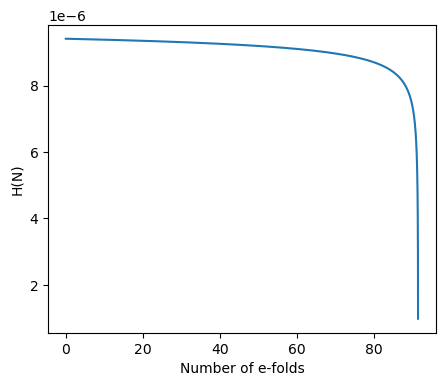

In [8]:
#Plot of Hubble function

fig, ax = plt.subplots(figsize=[5, 4])

ax.plot(N_bkg, Hubble_interp(N_bkg))

#ax.set_yscale('log')
ax.set_ylabel('H(N)')
ax.set_xlabel('Number of e-folds')

In [9]:
# Looking for end of inflation: when eps1 =1

Nk = 55 #choosed value for the pivot scale. This is Delta N_*, then N_star = N_end - Delta N_star

for i in range(N_iter):
    if (eps1_array[i] - 1 > 1e-20):
        N_end = N_bkg[i]
        print("Nend =", N_end)
        break

N_star = N_end - Nk
print("Nstar =", N_star) #If for your model N_star does not exist, you can change the initial conditions up to a choice which allows to obtain it. 

Nend = 91.20912091209121
Nstar = 36.20912091209121


In [10]:
# In the case your model does not provide a natural end of inflation, you can just make an arbitrary choice for phi_* and then find the corrispective N_* 
#(aways set everything helping with the initial conditions)

#Nk = 55 #choosed value for the pivot scale. This is Delta N_*, then N_star = N_end - Delta N_star

#Setting the arbitrary value for phi_* and finding N_star from it. 
#phi_star = -0.3 * np.sqrt(8 * np.pi) * Mpl #defining an arbitrary phi*

#where_phi_star = np.where(np.abs(phi_bkg - phi_star) < 1e-3)[0] # Finding N=N_* at which phi=phi_*
#N_star = N_bkg[where_phi_star][0]
#print("Nstar =", N_star)

#N_end = N_star + Nk 
#print("N_end =", N_end)

In [11]:
#Values of epsilon_i and H at the pivot scale: 

print(eps1(N_star))
print(eps2(N_star))
print(eps3(N_star))
print(eps4(N_star))
print(Hubble_interp(N_star))

0.00055465898365131
0.024317387386176496
0.018200664298581814
0.016948158470852976
9.276387572507413e-06


## ***Mukhanov and Sasaki equation***


The Mukhanov and Sasaki equation is the one which describes the dynamics of the inflaton perturbations $u = a \delta \phi$. It can be written in the following form (in the Fourier space): 

$u''_k + \left( k^2 c^2_s - \frac{z''}{z} \right) u_k =0 \ \ \ where \ \ \ (...)'\equiv \frac{d(...)}{d\tau} $. 

Using the Hubble flow and the sound functions it is possibile to find

$\frac{z''}{z} = a^2H^2 \left[ 2-\varepsilon_1 +\frac{3ɛ_2}{2}-3s -\frac{ɛ_1 ɛ_2}{2} +ɛ_1 s + \frac{ɛ^2_2}{4} + s^2 + \frac{ɛ_2ɛ_3}{2}-\frac{\dot s}{H}\right]$.

In the case of $c_s=1$ we have $s=0$ and $\dot s=0$ and have

$\frac{z''}{z} = a^2H^2 \left[ 2-\varepsilon_1 +\frac{3ɛ_2}{2} -\frac{ɛ_1 ɛ_2}{2}  + \frac{ɛ^2_2}{4}  + \frac{ɛ_2ɛ_3}{2}\right]$.



Reducing our II order equation to a first order equation by defining 

$f_k = u'_k,$

the system to solve is

$\begin{cases}
f'_k = \left(Z-k^2 \right)u_k \\
f_k = u'_k 
\end{cases}$

where

$\begin{cases}
Z = \frac{z''}{z} =a^2H^2 \left[ 2-\varepsilon_1 +\frac{3ɛ_2}{2} -\frac{ɛ_1 ɛ_2}{2}  + \frac{ɛ^2_2}{4}  + \frac{ɛ_2ɛ_3}{2}\right] \\
ɛ_1 =  \frac{1}{M^2_{\text{Pl}}}\frac{\phi^2_N}{2} \\
ɛ_{2} = \frac{d\ln |ɛ_1|}{dN}=  \frac{2\phi_{NN}}{\phi_N}\\
ɛ_{3} = \frac{d\ln |ɛ_2|}{dN}= \frac{\phi_{NNN}}{\phi_{NN}}-\frac{\phi_{NN}}{\phi_{N}}
\end{cases}$.

We need to split the real and the imaginary part: 

$u_k = \Re [u_k] + i \Im [u_k] $,

which have different initial conditions: 

$\Re [u_k] \sim \frac{1}{\sqrt{2k}} \ \ \ and \ \ \ \Re [u'_k]\sim 0$

$\Im [u_k] \sim 0 \ \ \ and \ \ \ \Im [u'_k]\sim -\sqrt{\frac{k}{2}}.$

Recall also that $dN = d\ln(a) \ ⇒ \ \ N_{end} -N= \ln (a_{end}/a)$ and then $a=a_{end}e^{N-N_{end}}$. We set $a_{end}$ from $k_* = a_*H_* = 0.05Mpc^{-1}$. 

Using another interval of integration we can set equivalentely: $a = a_{i}e^{N}$ and set $a_i$ with $k_*$ as well.

Switching from $\tau$ to $N$ we can obtain the equation


$ u_{k_{NN}} = [ɛ_1-1] u_{k_{N}} + \frac{1}{a^2H^2}(Z-k^2)u_k,$
then

$\begin{cases}
f_{k_{N}} = [ɛ_1-1] f_k + \frac{1}{a^2H^2}(Z-k^2)u_k \\ u_{k_{N}}=f_k 
\end{cases}$, 


and the only one IC which changes is 

$\Im[u_N] \sim -\frac{1}{a_{i}e^{N} H(N)} \sqrt{\frac{k}{2}}$.

The scalar curvature is defined as

$\mathcal{R}_k = \frac{u_k}{a \sqrt{2\varepsilon_1} M_{Pl}} = \frac{u_kH}{\psi a}$

The scalar Primordial Power Spectrum is then defined as

$\mathcal{P}_\mathcal{R}(k) = \frac{k^3}{2\pi^2} |\mathcal{R}_k|^2 = \frac{k^3}
{4\pi^2 a^2 \varepsilon_1} |u_k|^2$.

For the tensor perturbations the power spectrum is just rescaled by $2\varepsilon_1$ with respect to the scalar one. Most of the times, such a quantity $\mathcal{P}_h =8 \mathcal{P}_T$ is used.


Let's start by imposing the $k_*$ value at which we have $\Delta N_* = 55$ and let's find the scale factor $a$ with respect to $N$. As soon as we have $a(N)$ we are able to define $Z$ for both for scalar and tensor, and then we are able to solve the MS equation.

In [12]:
#We fix N_* to k_* = 0.06875 h Mpc^-1=0.05 Mpc^-1. 

#dN = dln(a), then it can be a a = a_end e^{N-Nend} or a = a_in e^N

k_star = 0.05

N_ini = 0
aini = k_star / np.exp(N_star-N_ini) / Hubble_interp(N_star)
aend = k_star / np.exp(N_star-N_end) / Hubble_interp(N_star)

print(aini, aend)

1.0143076762909616e-12 4.1475117361133026e+27


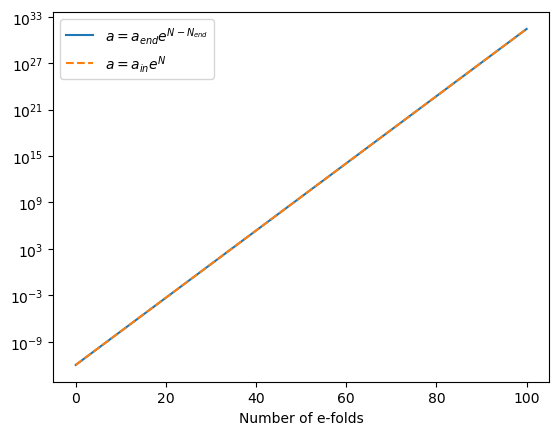

In [13]:
#Plots of a(N) computed in two different manner

plt.plot(N_bkg, aini * np.exp(N_bkg), label = r"$a=a_{end}e^{N-N_{end}}$ ")
plt.plot(N_bkg, aend * np.exp(N_bkg-N_end), ls='--',  label = r"$a=a_{in}e^{N}$ ")

plt.yscale('log')
plt.xlabel('Number of e-folds')
plt.legend()

In [14]:
#Definition of a(N):

def aN(N):
    return aini * np.exp(N)
    #return aend * np.exp(N-N_end) #In the case we choose the other way to express a

#Definitions of zeta for scalar and tensor: 

# scalar
def zeta_r(N):
    return (aN(N) * Hubble_interp(N))**2 * (2 - eps1(N) + 1.5 * eps2(N) - eps1(N) * eps2(N) / 2 + eps2(N)**2 / 4 + eps2(N)*eps3(N) / 2)

# tensor
def zeta_t(N):
    return 2 * (aN(N) * Hubble_interp(N))**2 + aN(N)**2 * Hubble_interp(N) * dHubble_interp(N)

For every $k$, we want to have a certain interval of integration of the MS equation (expecially due to numerical reasons). 

We can define the horizon for a given $N$ as $\kappa=a(N)H(N)$. For every $k$ we want to integrate between a value of $N$ which is surely sub-horizon and a value of $N$ which is surely super-horizon. We impose we are deep subhorizon for $10^{-5}\kappa$ and deep super horizon when $10^2\kappa$. Then, we find the value for which $k=10^{-3}\kappa$ and $k = 10^{2}\kappa$ these two values defines the interval of integration. 

Because $k$ and $h$ are both fixed, it is quite impossibile to obtain exactly $k=subhorizon$ and $k=superhorizon$. For this motivation we can compute $|k-subhorizon|$, $|k-superhorizon|$ and find $N$ which minimize the two absolute values (the value nearest $0$). 

Because we want to compute everything varying $k$, we define the whole script using arrays.

In [15]:
#N_bounds(k,N) gives the interval of integration for the given k.

def N_bounds(k, N):
    horizon = aN(N) * Hubble_interp(N)
    sub_hr = 1e2 * horizon 
    super_hr = 1e-5 * horizon 

    test_in = np.absolute(sub_hr - k) 
    test_fin = np.absolute(super_hr - k) 
    
    Nii = np.where( test_in == np.min(test_in) )[0][0] 
    Nff = np.where( test_fin == np.min(test_fin) )[0][0] 
    #print(Nii)
    #print(Nff)

    return N[Nii], N[Nff]

#Here N[Nii] is the value of N for which WITH OUR k we are sub_horizon, 
#N[Nff] is the value of N for which WITH OUR k we are super_horizon (given both the definiton of super and subhorizon).
# [N[Nii], N[Nff]] will be the interval of integration. 

In [16]:
#As just an example, let's start by solving the scalar perturbation for just a value of k, say k=0.01 Mpc-1.


k_num = 1
k_win = [0.01]

N_num = 1000
N_win = np.zeros((k_num, N_num))

N_win2 = np.zeros(N_num)
N_win2 = np.linspace(0, N_end, N_num) #It is always the same interval [0, end of inflation] divided into N_num sections

for i in range(k_num):
    Ni, Nf = N_bounds(k_win[i], N_win2) #Start and stop of the MS range of integration are given by N_bounds with k_win[i] as argument
    N_win[i] = np.linspace(Ni, Nf, N_num) #Given k_win this gives the range of integration


Re_sol = np.zeros((k_num, N_num, 2))
Im_sol = np.zeros((k_num, N_num, 2))

def muksas(S, N): #Mukhanov and Sasaki equation
    u, f = S

    return [f, (eps1(N) - 1)*f + 1 / (aN(N) * Hubble_interp(N))**2 * (zeta_r(N) - k_win[i]**2)*u]

for i in range(k_num): #Initial conditions + solving the MS equation for every k_num
    Re_IC = [1 / np.sqrt(2 * k_win[i]), 0]
    Im_IC = [0, -np.sqrt(k_win[i] / 2) / (aN(N_win[i,0]) * Hubble_interp(N_win[i,0]))]

    Re_sol[i] = odeint(muksas, Re_IC, N_win[i])
    Im_sol[i] = odeint(muksas, Im_IC, N_win[i])
    print(N_win[i].shape)

(1000,)


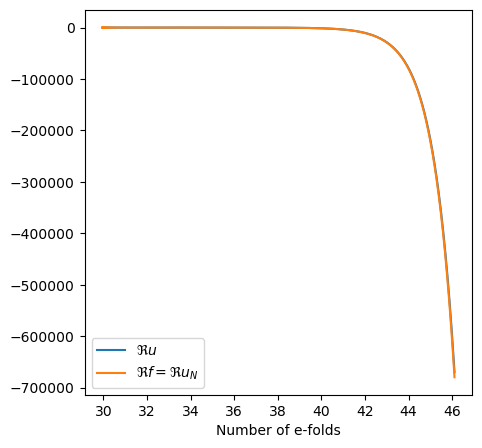

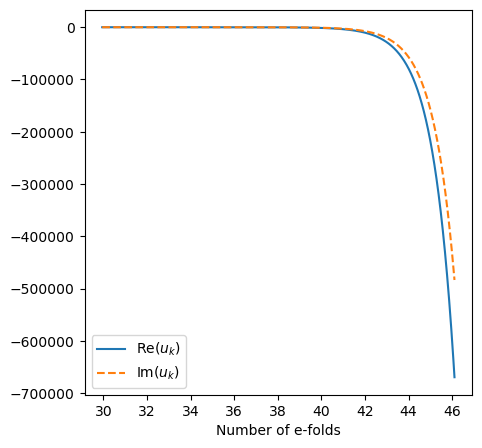

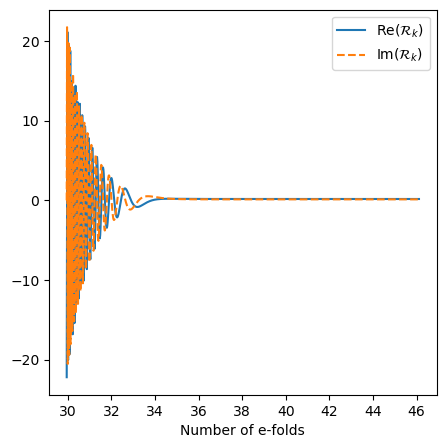

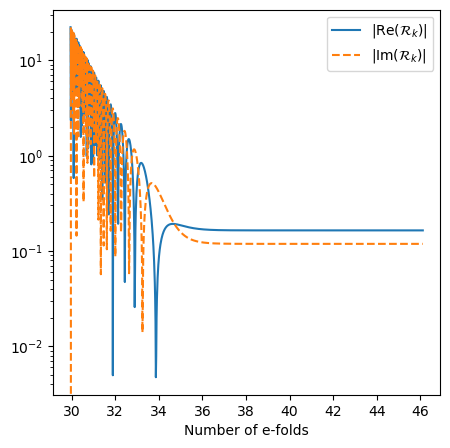

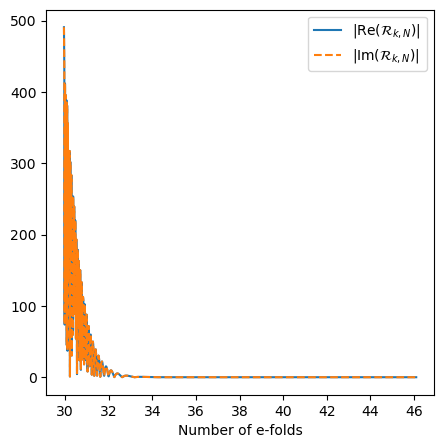

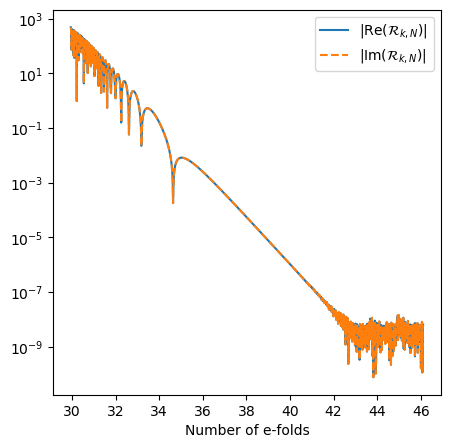

In [17]:
# Some useful plots of the real and imaginary part of the solution, their absolute values, and their derivative.
 
#Real part of u and real part of u_N, namely its derivative with respect to N
ki=0
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(N_win[ki], Re_sol[ki,:,0], label=r'$\Re{u}$')
ax.plot(N_win[ki], Re_sol[ki,:,1], label=r'$\Re{f}=\Re{u_N}$')
ax.set_xlabel('Number of e-folds')
plt.legend()

#Real and imaginary part of u
ki=0
fig, ax = plt.subplots(figsize=[5, 5]) 
plt.plot(N_win[ki], Re_sol[ki,:,0], label=r'Re($u_k$)')
plt.plot(N_win[ki], Im_sol[ki,:,0], label=r'Im($u_k$)', ls='--')
plt.xlabel('Number of e-folds')
plt.legend()

#Real and imaginary parts of scalar curvature perturbation
ki = 0
fig, ax = plt.subplots(figsize=[5, 5]) 
plt.plot(N_win[ki], Re_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki])), label=r'Re(${\cal R}_k$)')
plt.plot(N_win[ki], Im_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki])), label=r'Im(${\cal R}_k$)', ls='--')
plt.xlabel('Number of e-folds')
plt.legend()

#Absolute values of real and imaginary parts of scalar curvature perturbation
fig, ax = plt.subplots(figsize=[5, 5]) 
plt.plot(N_win[ki], abs(Re_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki]))), label=r'|Re(${\cal R}_k$)|')
plt.plot(N_win[ki], abs(Im_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki]))), label=r'|Im(${\cal R}_k$)|', ls='--')
plt.xlabel('Number of e-folds')
plt.legend()
plt.yscale('log')

#Absolute values of the derivatives of scalar curvature perturbation, real and imaginary parts.
fig, ax = plt.subplots(figsize=[5, 5]) 
plt.plot(N_win[ki], abs(np.gradient(Re_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki])), 0.05)), label=r'|Re(${\cal R}_{k,N}$)|')
plt.plot(N_win[ki], abs(np.gradient(Re_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki])), 0.05)), label=r'|Im(${\cal R}_{k,N}$)|', ls='--')
plt.xlabel('Number of e-folds')
plt.legend()

#Same plot as before, but in log scale
fig, ax = plt.subplots(figsize=[5, 5]) 
plt.plot(N_win[ki], abs(np.gradient(Re_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki])), 0.05)), label=r'|Re(${\cal R}_{k,N}$)|')
plt.plot(N_win[ki], abs(np.gradient(Re_sol[ki,:,0] * ( Hubble_interp(N_win[ki]) / psi_interp(N_win[ki]) / aN(N_win[ki])), 0.05)), label=r'|Im(${\cal R}_{k,N}$)|', ls='--')
plt.xlabel('Number of e-folds')
plt.legend()
plt.yscale('log')

For each $k$ under consideration, we define a window of $N$ within which we integrate our differential equation. The PPS is then computed at a specific point within this window, chosen to ensure we are well into the super-horizon regime.
For instance, we can compute the power spectrum at points 0, 1, 2, 3, ..., N e-folds before the end of the window. These points are selected to ensure that we are certainly in the super-horizon region.


In [18]:
#Now we solve the MS equation for different k_num =94 different values of k in the window k_win = [10^{-5}, 10^{3}] Mpc-1
# k_num =94 is choosen in order to have k_win[43] ≃ k_star

k_num = 94 
k_win = np.logspace(-5, 3, k_num)

N_num = 100000
N_win = np.zeros((k_num, N_num))

N_win2 = np.zeros(N_num)
N_win2 = np.linspace(0, N_end, N_num)

for i in range(k_num):
    Ni, Nf = N_bounds(k_win[i], N_win2)
    N_win[i] = np.linspace(Ni, Nf, N_num)


Re_sol = np.zeros((k_num, N_num, 2))
Im_sol = np.zeros((k_num, N_num, 2))

def muksas(S, N): #Mukhanov and Sasaki equation, here we redefine it just for the sake of completness
    u, f = S

    return [f, (eps1(N) - 1)*f + 1 / (aN(N) * Hubble_interp(N))**2 * (zeta_r(N) - k_win[i]**2)*u]

for i in range(k_num): #Initial conditions + solving the MS equation for every k_num
    Re_IC = [1 / np.sqrt(2 * k_win[i]), 0]
    Im_IC = [0, -np.sqrt(k_win[i] / 2) / (aN(N_win[i,0]) * Hubble_interp(N_win[i,0]))]

    Re_sol[i] = odeint(muksas, Re_IC, N_win[i])
    Im_sol[i] = odeint(muksas, Im_IC, N_win[i])
    
sol = Re_sol[:,:,0]**2 + Im_sol[:,:,0]**2 #the complete solution is obtained by square-summing the Re and Im solutions.

In [19]:
#k_win[49] is very close to k_*=0.05, that's why we choose k_num =94 for the window k_win = [10^{-5}, 10^{3}] Mpc-1.

k_win[43]

0.049994788007281375

Since the curvature perturbation freezes at super-Hubble scales, it is sufficient to calculate the power spectrum for the modes when they are at super-Hubble scales (after horizon crossing) instead of calculating it at the end of inflation.

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

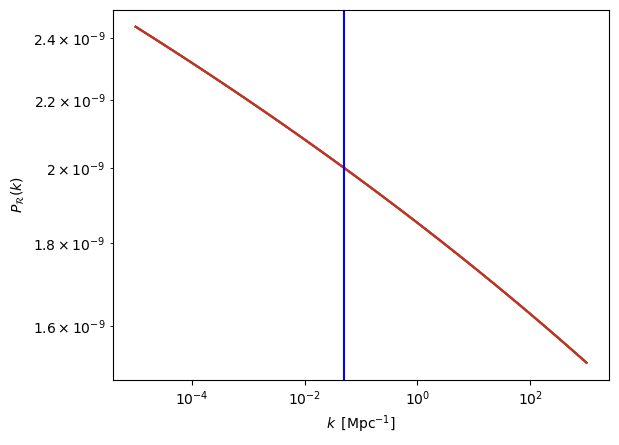

In [20]:
#Scalar curvature (computed at # e-folds before the last value of N_win) and its plot
 
R21 = sol[:,-3] * (Hubble_interp(N_win[:,-3]) / psi_interp(N_win[:,-3]) / aN(N_win[:,-3]))**2 #Scalar PPS 2 e-folds before the last value of N_win
R22 = sol[:,-4] * (Hubble_interp(N_win[:,-4]) / psi_interp(N_win[:,-4]) / aN(N_win[:,-4]))**2 #Scalar PPS 3 e-folds before the last value of N_win
R23 = sol[:,-5] * (Hubble_interp(N_win[:,-5]) / psi_interp(N_win[:,-5]) / aN(N_win[:,-5]))**2 #Scalar PPS 4 e-folds before the last value of N_win
R2 = sol[:,-1] * (Hubble_interp(N_win[:,-1]) / psi_interp(N_win[:,-1]) / aN(N_win[:,-1]))**2  #Scalar PPS 0 e-fold before the last value of N_win


#The scalar power spectrum and its plot:
plt.loglog(k_win, R2 * k_win**3 / (2 * np.pi**2))
plt.loglog(k_win, R21 * k_win**3 / (2 * np.pi**2) )
plt.loglog(k_win, R22 * k_win**3 / (2 * np.pi**2) )
plt.loglog(k_win, R23 * k_win**3 / (2 * np.pi**2) )
plt.axvline(x = k_star, color = 'b', label = 'axvline - full height')
#plt.axhline(y = 1.05855106e-10, color = 'b', label = 'axvline - full height')

plt.ylabel(r'$P_{\cal R}(k)$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

In [21]:
# Solving the tensor perturbations


Re_sol_t = np.zeros((k_num, N_num, 2))
Im_sol_t = np.zeros((k_num, N_num, 2))

def muksas(S, N): #Mukhanov and Sasaki equation for tensor perturbation (note zeta_t(N))
    u, f = S

    return [f, (eps1(N) - 1)*f + 1 / (aN(N) * Hubble_interp(N))**2 * (zeta_t(N) - k_win[i]**2)*u]

for i in range(k_num): #Initial conditions + solving the MS for every k
    Re_IC = [1 / np.sqrt(2 * k_win[i]), 0]
    Im_IC = [0, -np.sqrt(k_win[i] / 2) / (aN(N_win[i,0]) * Hubble_interp(N_win[i,0]))]

    Re_sol_t[i] = odeint(muksas, Re_IC, N_win[i])
    Im_sol_t[i] = odeint(muksas, Im_IC, N_win[i])
    
sol_t = Re_sol_t[:,:,0]**2 + Im_sol_t[:,:,0]**2 #complete solution by square-summing the Re and Im solution

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

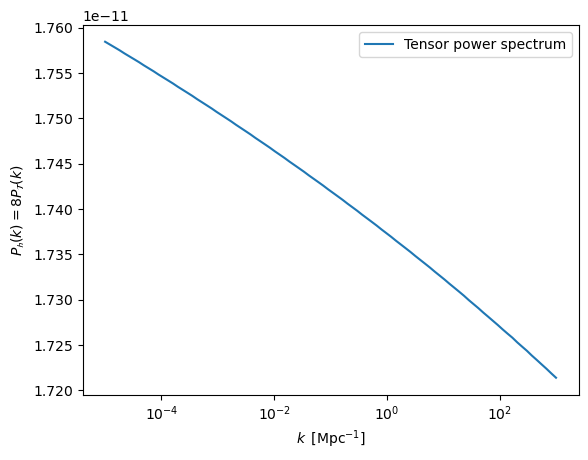

In [22]:
#Tensor curvature (computed only 0 e-fold before the last value of N_win) and its plot

h2 = sol_t[:,-1] * (1 / aN(N_win[:,-1]))**2 


# Tensor PPS and its plot
plt.plot(k_win, h2 * k_win**3 / (2 * np.pi**2) * 8 , label='Tensor power spectrum')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$P_{\cal h}(k) = 8P_{\cal T}(k)$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

## The PPS normalization procedure:

 Our renormalization procedure involves five steps, taking into account the possibility of defining different coupling constants (the mass in this case, or more generally $V_0$) for the theory in both analytical and numerical computations for the scalar and tensorial PPS, to ensure the different PPS (numerical, and analytical up to a certain order) match at the pivot scale $k_*$. These steps are implemented in the various PyPPSinflation notebooks. 

Each of these steps is implemented in the different PyPPSinflation notebooks, ensuring that the power spectra are correctly renormalized to match at the pivot scale $k_*$.


1. **Numerical Computations:** We begin with the numerical computations, defining a single coupling constant, e.g., `m2num_initial`. After obtaining the numerical PS, we aim for it to be $2 \times 10^{-9}$ at $k_*$. We interpolate the numerical power spectrum and compute the ratio between $2 \times 10^{-9}$ and its value at $k_*$. This ratio is then used to renormalize the coupling constant. Actually, we suggest to take 'm2num_initial' identical to the scalar analytical mass you obtain in the second step (3rd notebook); with such a choice, it is better to perform the renormalization by starting from the second step and take this step as second one. 

2. **Analytical Computations (Scalar and Tensor):** For the analytical script, we define two separate coupling constants: one for scalar quantities and another for tensorial quantities. We set the scalar coupling constant by ensuring $\mathscr{P}_R (k_*) = 2 \times 10^{-9}$ and use the relation $\mathcal{P}_{\mathcal{R}_0}(k_*) = \frac{H^2}{8\pi^2 \varepsilon_1 M^2_{Pl}}$. If the model also specifies the tensorial PS value at $k_*$ ($\mathcal{P}_h(k_*)$), we set the tensorial coupling constant using $\mathcal{P}_{\mathcal{h}_0}(k_*) = \frac{2 H^2}{\pi^2 M^2_{Pl}}$. If not, we initially set it equal to the scalar coupling constant and adjust later (in step 4).

3. **Renormalizing Analytical Scalar Coupling Constant:** We may further renormalize the analytical scalar coupling constant by comparing the analytical and numerical scalar power spectra at the pivot scale. This step ensures a better match between the two scalar power spectra.

4. **Renormalizing Analytical Tensorial Coupling Constant:** If the tensorial PS value at the pivot scale is not provided by the model, we renormalize the analytical tensorial coupling constant similarly to the scalar one. We compute the ratio between the analytical and numerical tensorial power spectra and use this ratio to adjust the tensorial coupling constant.



Here the normalization procedure for the numerical computation:


We want $\mathscr{P}_S(k_{star}) = 2\times 10^{-9}$; then, we adopt the following renormalization: we first interpolate the PS in order that we can compute it at $k_*$. Then, we compute the ratio $\frac{2\times 10^{-9}}{\mathscr{P}_S(k_{star})}$ and, because $\mathscr{P}_S(k_{star}) \sim m^2$, we renormalize $m^2$ with the value of this ratio. 

In [23]:
#Renormalization of the coupling constant. 

PSs_interp_num = interp1d(k_win, R2 * k_win**3 / (2 * np.pi**2), kind='linear')
print("Value of the scalar PS at k_star = ", PSs_interp_num(k_star) )
print("The renormalization factor is",(2e-9)/PSs_interp_num(k_star) )

Value of the scalar PS at k_star =  2.0000003009175106e-09
The renormalization factor is 0.9999998495412674


## Spectral indices and their runnings

By computing the derivatives of log(PPS), we can compute the spectral indices $n_s$ and $n_t$. Further differentiations allow us to compute the runnings $\alpha_s$ and $\alpha_t$, as well as the runnings of the runnings $\beta_s$ and $\beta_t$.

As we proceed with higher-order derivatives, the numerical solutions exhibit significant oscillations. This is an issue for the comparisons with the analytical results up to the third order in the next notebook. To address this issue, we fit the results using a power series in $\ln\left(\frac{k}{k_*}\right)$.


In [24]:
# Calculating $n_S$, $n_T$, $\alpha_S$, $\alpha_T$, $\beta_S$, $\beta_T$ and the tensor-to-scalar ratio $R$ without interpolation
# (We have verified that interpolating the PPS first does not alter the results. Therefore, we prefer to perform all calculations without interpolation. Interpolation will be done at the end to obtain all values at $k_*$.)

#PPS and their logarithms
P_S = R2 * k_win**3 / (2 * np.pi**2)
P_h = h2 * k_win**3 / (2 * np.pi**2) * 8  
logPS = np.log(P_S)
logPT = np.log(P_h)
lnk=np.log(k_win/k_star)

#Spectral indices
n_S =1+ np.gradient(logPS, lnk)
n_T = np.gradient(logPT, lnk)

#Runnings of the spectral indices
alpha_S = np.gradient(n_S, lnk)
alpha_T = np.gradient(n_T, lnk)

# Runnings of the runnings
beta_S = np.gradient(alpha_S, lnk)
beta_T = np.gradient(alpha_T, lnk)

#Tensor-to-scalar ratio
R_k=P_h/P_S

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

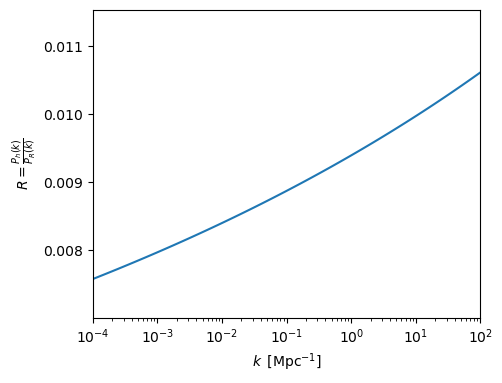

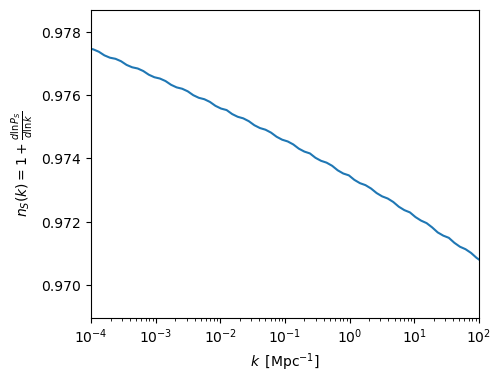

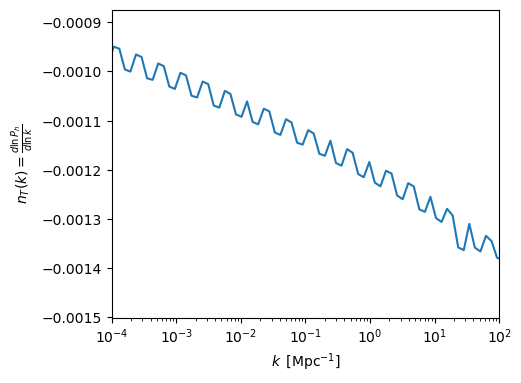

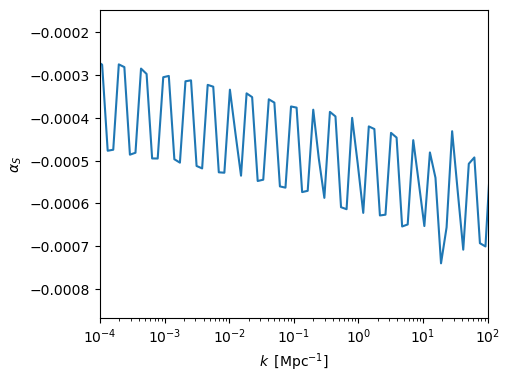

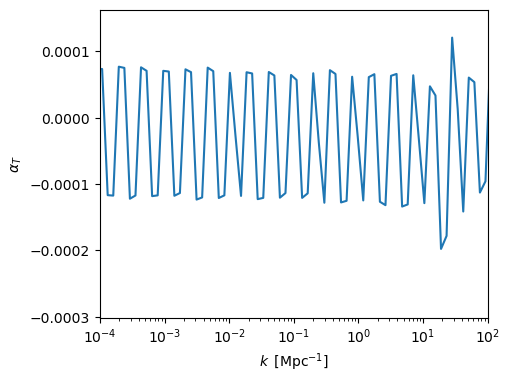

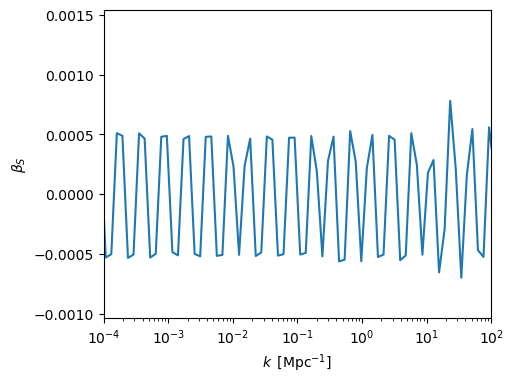

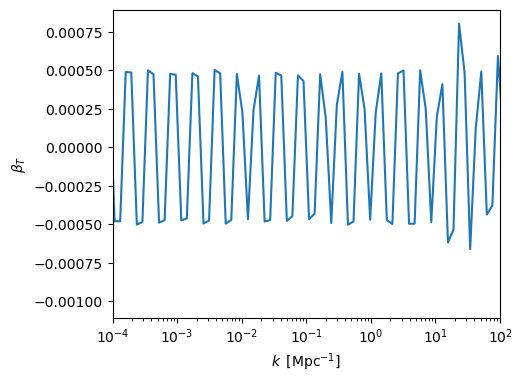

In [25]:
#Tensor to scalar ratio plot
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, R_k)
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$R= \frac{P_h(k)}{P_R(k)}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#n_s plot
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, n_S)
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_S(k) =1+\frac{d\ln P_S}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#n_t plot
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, n_T)
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_T(k) =\frac{d\ln P_h}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#alpha_s plot
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, alpha_S)
ax.set_xscale('log')
#ax.set_ylim([-0.001,-0.0004])
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\alpha_S$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#alpha_t plot
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, alpha_T)
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\alpha_T$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#beta_s plot
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, beta_S)
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\beta_S$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#beta_t plot
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, beta_T)
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\beta_T$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')


**Smoothing the runnings and the runnings of the runnings by fitting $n_s$ and $n_t$**:

Let's try to fit $n_S$ and $n_T$ to obtain smoother runnings. 

Since our plots are in log-log scales, fitting a polynomial requires using $\ln\left(\frac{k}{k_*}\right)$. This approach is also beneficial for comparisons with the analytical results, which are expressed as series in $\ln\left(\frac{k}{k_*}\right)$. Hence, to obtain a good comparison with the analytical results, we perform the fit up to the third order in $\ln\left(\frac{k}{k_*}\right)$.


In [26]:
#Fitting n_s
n_S_fitting_params = np.polyfit (np.log(k_win/k_star), n_S,3, rcond=None, full=False, w=None, cov=False) #if you want the fit up to an order j, substitute 3 with j.
print("n_S fitting parameters=",n_S_fitting_params)
n_S_fitted=+n_S_fitting_params[0]*np.log(k_win/k_star)**3+n_S_fitting_params[1]*np.log(k_win/k_star)**2+n_S_fitting_params[2]*np.log(k_win/k_star) +n_S_fitting_params[3]

#Fitting n_t
n_T_fitting_params = np.polyfit (np.log(k_win/k_star), n_T,3, rcond=None, full=False, w=None, cov=False)
print("n_T fitting parameters=",n_T_fitting_params)
n_T_fitted=+n_T_fitting_params[0]*np.log(k_win/k_star)**3+n_T_fitting_params[1]*np.log(k_win/k_star)**2+n_T_fitting_params[2] *np.log(k_win/k_star) +n_T_fitting_params[3]


n_S fitting parameters= [-1.43160168e-07 -8.56625800e-06 -4.59839215e-04  9.74883461e-01]
n_T fitting parameters= [-1.51346354e-08 -6.15233933e-07 -2.77128280e-05 -1.11791897e-03]


In [27]:
#Computing alpha_S and alpha_T with n_S and n_T fitted

alpha_S_fitted = np.gradient(n_S_fitted, lnk)
alpha_T_fitted = np.gradient(n_T_fitted, lnk)

In [28]:
#Computing beta_S and beta_T with n_S and n_T fitted

beta_S_fitted = np.gradient(alpha_S_fitted, lnk)
beta_T_fitted = np.gradient(alpha_T_fitted, lnk)

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

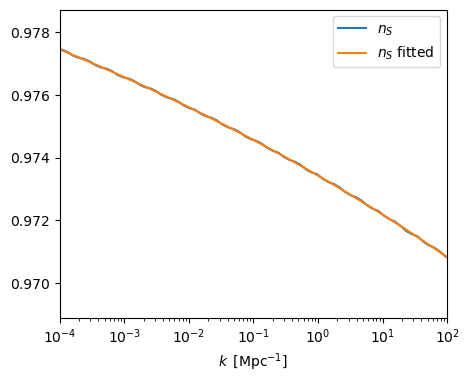

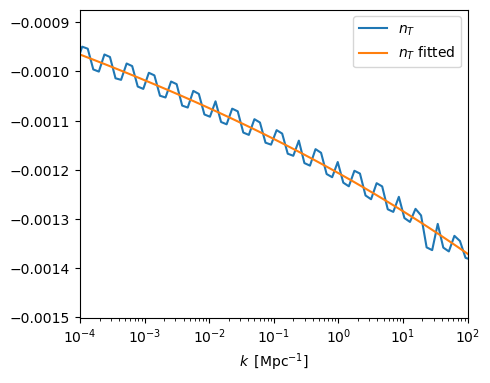

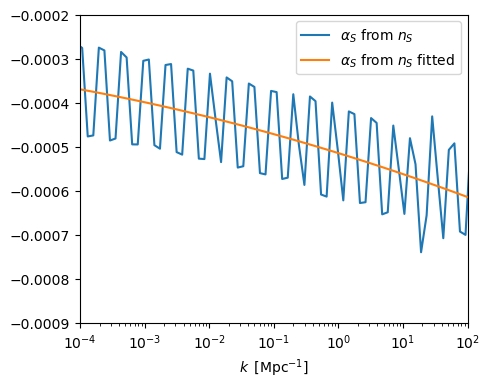

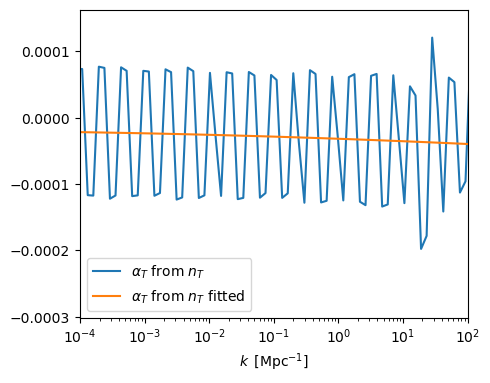

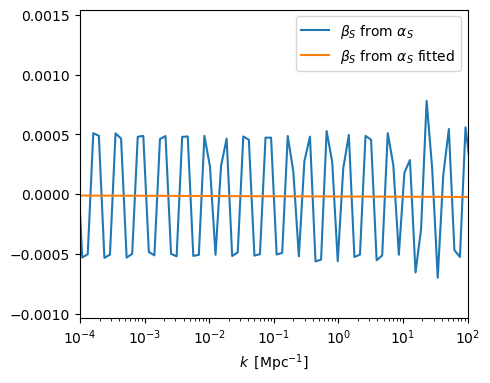

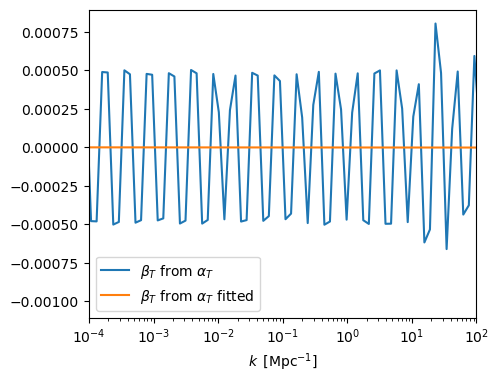

In [29]:
# n_S ordinary vs fitted
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, n_S, label ="$n_S$")
ax.plot(k_win,  n_S_fitted, label ="$n_S$ fitted")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

# n_T ordinary vs fitted
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, n_T, label ="$n_T$")
ax.plot(k_win,  n_T_fitted, label ="$n_T$ fitted")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

#alpha_S ordinary vs alpha_S computed with fitted n_S
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, alpha_S, label="$\\alpha_S$ from $n_S$")
ax.plot(k_win, alpha_S_fitted, label="$\\alpha_S$ from $n_S$ fitted")
ax.set_xscale('log')
ax.set_ylim([-0.0009,-0.0002])
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#alpha_T ordinary vs alpha_T computed with fitted n_T
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, alpha_T, label="$\\alpha_T$ from $n_T$")
ax.plot(k_win, alpha_T_fitted, label="$\\alpha_T$ from $n_T$ fitted")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#beta_S ordinary vs beta_S computed with fitted n_S
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, beta_S, label="$\\beta_S$ from $\\alpha_S$")
ax.plot(k_win, beta_S_fitted, label="$\\beta_S$ from $\\alpha_S$ fitted")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')


#beta_T ordinary vs beta_T computed with fitted n_T
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, beta_T, label="$\\beta_T$ from $\\alpha_T$")
ax.plot(k_win, beta_T_fitted, label="$\\beta_T$ from $\\alpha_T$ fitted")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')





In [30]:
# Interpolations to find the values at k_star

R_k_interp = interp1d(k_win, R_k, kind='linear')
n_S_interp = interp1d(k_win, n_S_fitted, kind='linear')
n_T_interp = interp1d(k_win, n_T_fitted, kind='linear')
alpha_S_interp = interp1d(k_win,alpha_S_fitted, kind='linear')
alpha_T_interp = interp1d(k_win, alpha_T_fitted, kind='linear')
beta_S_interp = interp1d(k_win,beta_S_fitted, kind='linear')
beta_T_interp = interp1d(k_win, beta_T_fitted, kind='linear')

In [31]:
#Values at k_star

print("R(k_star) = ",R_k_interp(k_star))
print("n_S(k_star) =",n_S_interp(k_star))
print("alpha_S(k_star) =",alpha_S_interp(k_star))
print("beta_S(k_star) =", beta_S_interp(k_star))
print("n_T(k_star) =",n_T_interp(k_star))
print("alpha_T(k_star) =",alpha_T_interp(k_star))
print("beta_T(k_star) =", beta_T_interp(k_star))

R(k_star) =  0.008716677347649101
n_S(k_star) = 0.9748834652334445
alpha_S(k_star) = -0.00045984466849252896
beta_S(k_star) = -1.713250742291908e-05
n_T(k_star) = -0.0011179187076709503
alpha_T(k_star) = -2.7713410336202432e-05
beta_T(k_star) = -1.2304669597879905e-06


In [32]:
#Let's compute the ratios between the original quantities and the fitted ones

#Spectral indices ratios
n_S_ratio = n_S/n_S_fitted
n_T_ratio = n_T/n_T_fitted

#Runnings ratios
alpha_S_ratio = alpha_S/alpha_S_fitted
alpha_T_ratio = alpha_T/alpha_T_fitted

#Runnings of the runnings ratios
beta_S_ratio = beta_S/beta_S_fitted
beta_T_ratio = beta_T/beta_T_fitted


Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

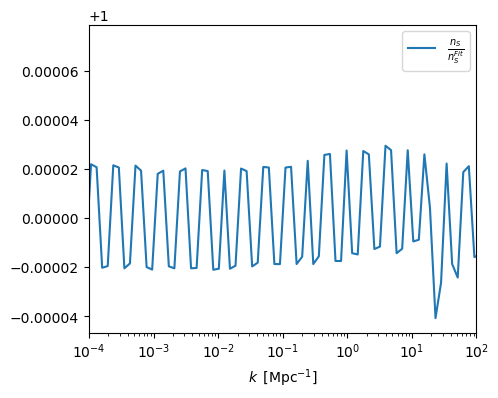

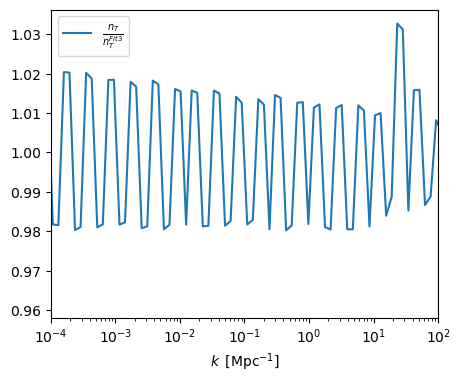

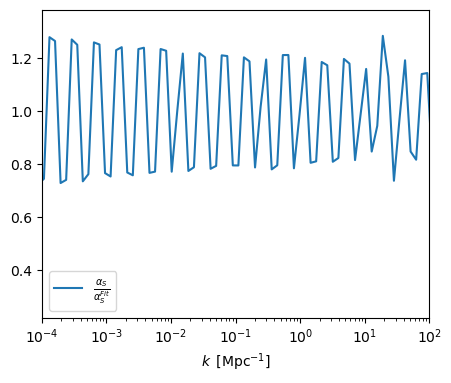

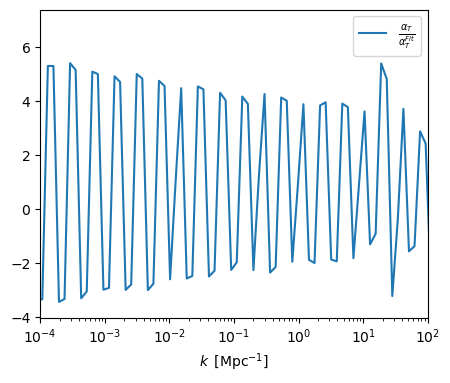

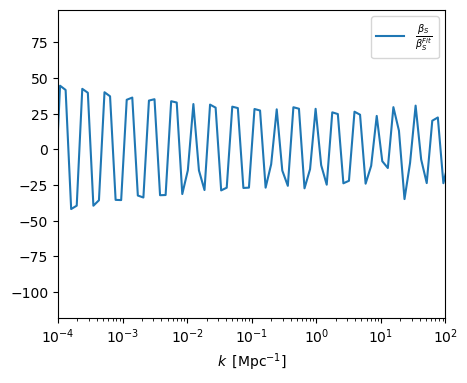

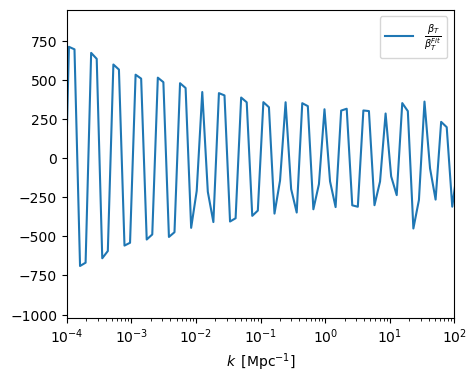

In [33]:
#n_S ratio
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,  n_S_ratio, label ="$\\frac{n_S}{n_S^{Fit}}$")
ax.set_xscale('log')
#ax.set_ylim([0.958,0.970])
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#n_T ratio
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,  n_T_ratio, label ="$\\frac{n_T}{n_T^{Fit3}}$")
ax.set_xscale('log')
#ax.set_ylim([0.958,0.970])
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#alpha_S ratio
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,  alpha_S_ratio, label ="$\\frac{\\alpha_S}{\\alpha_S^{Fit}}$")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#alpha_T ratio
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,  alpha_T_ratio, label ="$\\frac{\\alpha_T}{\\alpha_T^{Fit}}$")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#beta_S ratio
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,  beta_S_ratio, label ="$\\frac{\\beta_S}{\\beta_S^{Fit}}$")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

#beta_T ratio
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,  beta_T_ratio, label ="$\\frac{\\beta_T}{\\beta_T^{Fit}}$")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.legend()
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')